# Attack on Adult using a Decision Tree

In this notebook I use the same dataset of the decision trees to build the shadow models and I keep all the elements generated by LIME, without filtering using the mean + std

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../.."
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Adult data

loading the Adult RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.adult import load_adult_data, load_adult_randomforest # type: ignore

BB = load_adult_randomforest()
BB_DATA = load_adult_data()

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8157
           1       0.79      0.61      0.69      2690

    accuracy                           0.86     10847
   macro avg       0.84      0.78      0.80     10847
weighted avg       0.86      0.86      0.86     10847



# Creating the explainer

In [4]:
explainer_training_data = BB_DATA['X_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(BB_DATA['categorical_features_mask']) if el], random_state=123)

def generate_data_lime(x, num_samples):
    return explainer.data_inverse(x, num_samples+1, 'gaussian')[1][1:]

# Generating the lime datasets

In [5]:
test_representatives_x = BB_DATA['X_attack_3_per_quantile']
test_representatives_y = BB_DATA['y_attack_3_per_quantile']
n_datasets = len(test_representatives_x)
print(n_datasets)

In [6]:
def generate_and_save(index, instance):
    # wrapper of the above functions to be able to generate the datasets in parallel
    output_path = OUTPUT_FOLDER / f"{index}"
    output_path.mkdir(exist_ok=True)
    balanced_dataset = generate_balanced_dataset(instance, 5000, BB, generate_data_lime)
    balanced_dataset.to_csv(output_path / "lime_generated.csv", index=False)
    with open(output_path / "instance.npy", "wb") as f:
        np.save(f, instance)


if not any([Path(OUTPUT_FOLDER / f"{j}" / "lime_generated.csv").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(processes=8) as pool:
        pool.starmap(generate_and_save, [*enumerate(test_representatives_x)])
else:
    print("The lime generated datasets already exist")

The lime generated datasets already exist


# Creating the Decision Trees

Creating the decision trees <span style="color:red"> if they don't already exist </span>.

In [7]:
from mlem.utilities import create_decision_tree

def train_decision_tree(datapath, model_name):
    lime_dataset = pd.read_csv(datapath / "lime_generated.csv")
    X_train, X_test, y_train, y_test = train_test_split(lime_dataset.drop('Target', axis=1).to_numpy(), lime_dataset.Target.to_numpy(), test_size=0.33, random_state=42)
    model_path = datapath / model_name
    if not model_path.exists():
        dt = create_decision_tree(X_train, y_train, use_halving=True) 
        save_pickle_bz2(model_path, dt)
        save_txt(datapath / "dt_classification_report.txt", classification_report(y_test, dt.predict(X_test)))

In [8]:
models_name = "dt.bz2"
if not any([Path(OUTPUT_FOLDER / f"{j}" / "dt.bz2").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(8) as pool:
        pool.starmap(train_decision_tree, [(Path(OUTPUT_FOLDER / f"{i}"), models_name) for i in range(len(test_representatives_x))])
else:
    print("The DecisionTrees already exist")

The DecisionTrees already exist


# Attack on the Decision Trees to create the attack models

Attack on the decision trees using the <span style="background: green">lime-generated dataset</span> labeled by the decision trees to create the shadow models.

In [9]:
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [10]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [11]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        f.write("Statistics on the lime generated dataset\n")
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

Run the attack only if it hasn't already been run

In [12]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(test_representatives_x))]):
    
    for path in [OUTPUT_FOLDER / f"{i}" for i in range(len(test_representatives_x))]:
        # load the local tree and label the noisy dataset
        local_tree = load_pickle_bz2(path / "dt.bz2")

        lime_dataset = pd.read_csv(path / "lime_generated.csv")
        lime_dataset_x = lime_dataset.drop('Target', axis=1)
        lime_dataset_y = lime_dataset.Target

        # compute fidelity and performances on the noisy dataset.
        compute_statistics_local_model(lime_dataset_x, lime_dataset_y, local_tree, BB, path, "statistics_limegenerated.txt")

        x_attack = lime_dataset_x.to_numpy()    
        y_attack = local_tree.predict(x_attack)

        path_shadow = str(path / "shadow")

        shadow_models = ShadowModelsManager(
            n_models=4,
            results_path=path_shadow,
            test_size=0.5,
            random_state=123,
            model_creator_fn=create_adaboost,
            categorical_mask=categorical_features_mask
        )
        # x_attack is the noisy dataset
        shadow_models.fit(x_attack, y_attack)

        # extracting the dataset for the attack models
        attack_models_dataset = shadow_models.get_attack_dataset()

        # saving the attack dataset
        attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

        # Creating the attack model for each label using Adaboost
        path_attack = str(path / "attack")
        attack_models = AttackModelsManager(
                results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
        )
        
        attack_models.fit(attack_models_dataset)
else:
    print("The attack models already exist")

The attack models already exist


By looking at the test reports of the attack models, it seems that they <span style="background: red">perform bad on both classes</span> with an accuracy of $\simeq .50$

# Creating the ensembles

In [13]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [14]:
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in range(len(test_representatives_x))]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in range(len(test_representatives_x))]

## Hard Voting

In [15]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.92      0.79     24558
         out       0.31      0.09      0.14     10526

    accuracy                           0.67     35084
   macro avg       0.51      0.50      0.47     35084
weighted avg       0.58      0.67      0.60     35084


Class 0
              precision    recall  f1-score   support

          in       0.70      0.97      0.81     20131
         out       0.30      0.03      0.05      8665

    accuracy                           0.69     28796
   macro avg       0.50      0.50      0.43     28796
weighted avg       0.58      0.69      0.58     28796


Class 1
              precision    recall  f1-score   support

          in       0.71      0.65      0.68      4427
         out       0.31      0.38      0.34      1861

    accuracy                           0.57      6288
   macro avg       0.51      0.51      0.51      6288
weighted avg       0.60      0.57      0.58 

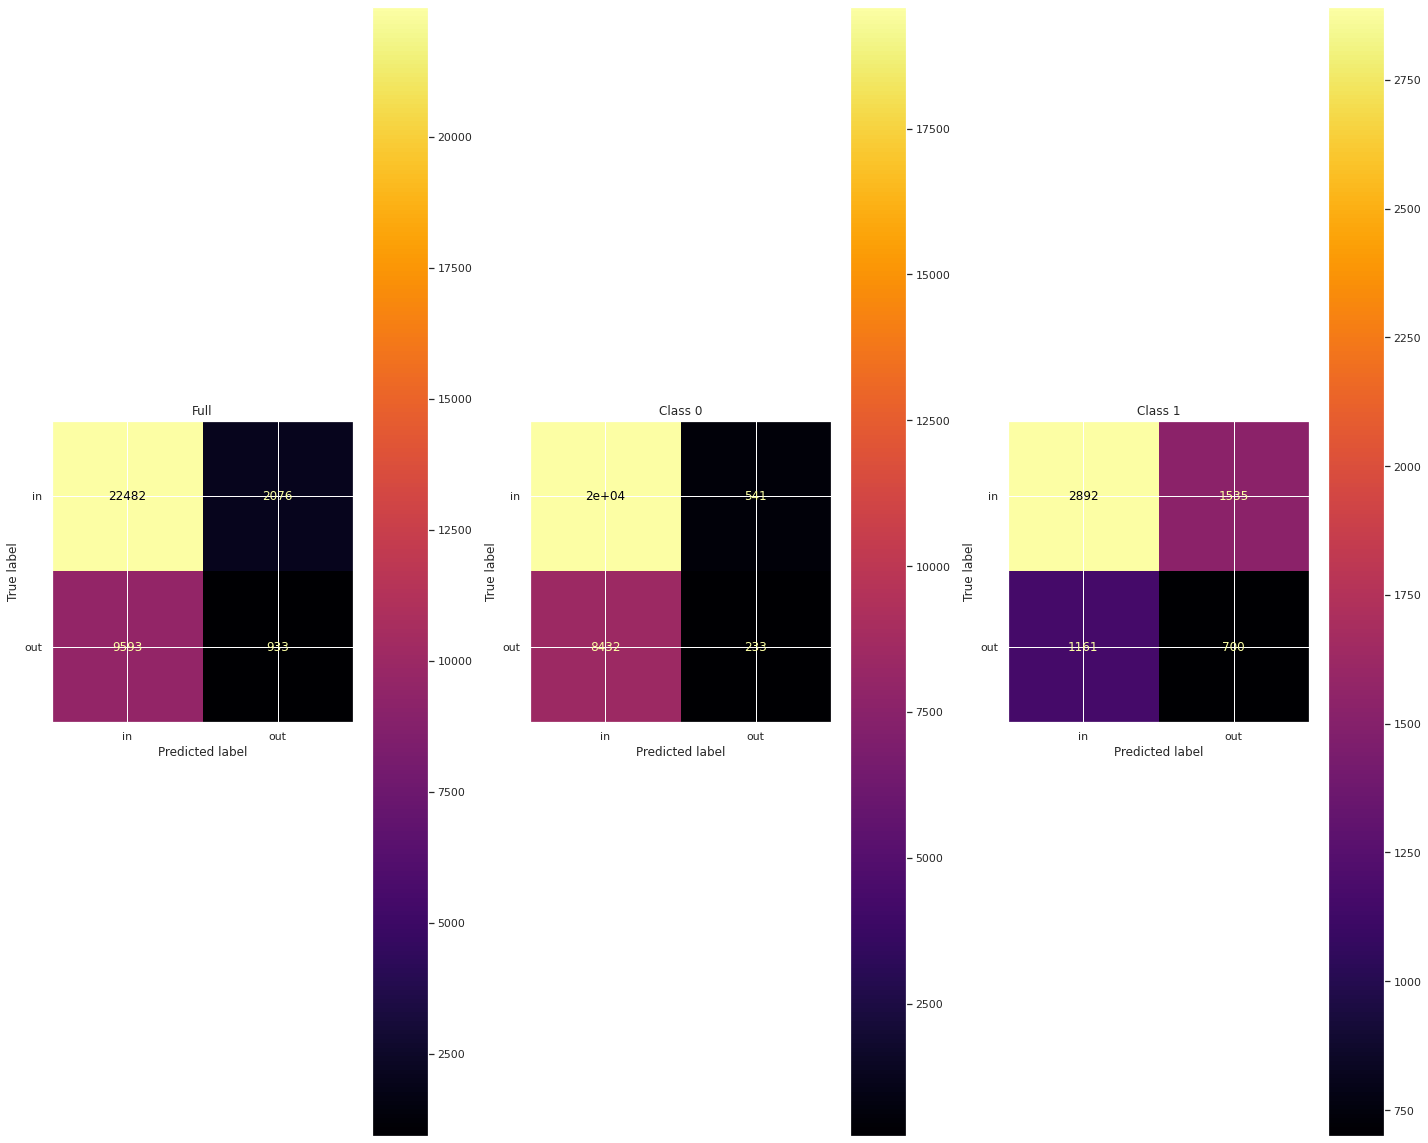

In [16]:
evaluate_attack(hv0, hv1, BB, BB_DATA)

In [ ]:
evaluate_attack(hv0, hv1, BB, BB_DATA, split_true_label=True)

## Soft Voting

In [17]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.91      0.79     25308
         out       0.30      0.09      0.14     10847

    accuracy                           0.66     36155
   macro avg       0.50      0.50      0.47     36155
weighted avg       0.58      0.66      0.60     36155


Class 0
              precision    recall  f1-score   support

          in       0.70      0.96      0.81     20353
         out       0.28      0.03      0.06      8766

    accuracy                           0.68     29119
   macro avg       0.49      0.50      0.44     29119
weighted avg       0.57      0.68      0.58     29119


Class 1
              precision    recall  f1-score   support

          in       0.71      0.68      0.69      4955
         out       0.31      0.34      0.32      2081

    accuracy                           0.58      7036
   macro avg       0.51      0.51      0.51      7036
weighted avg       0.59      0.58      0.58 

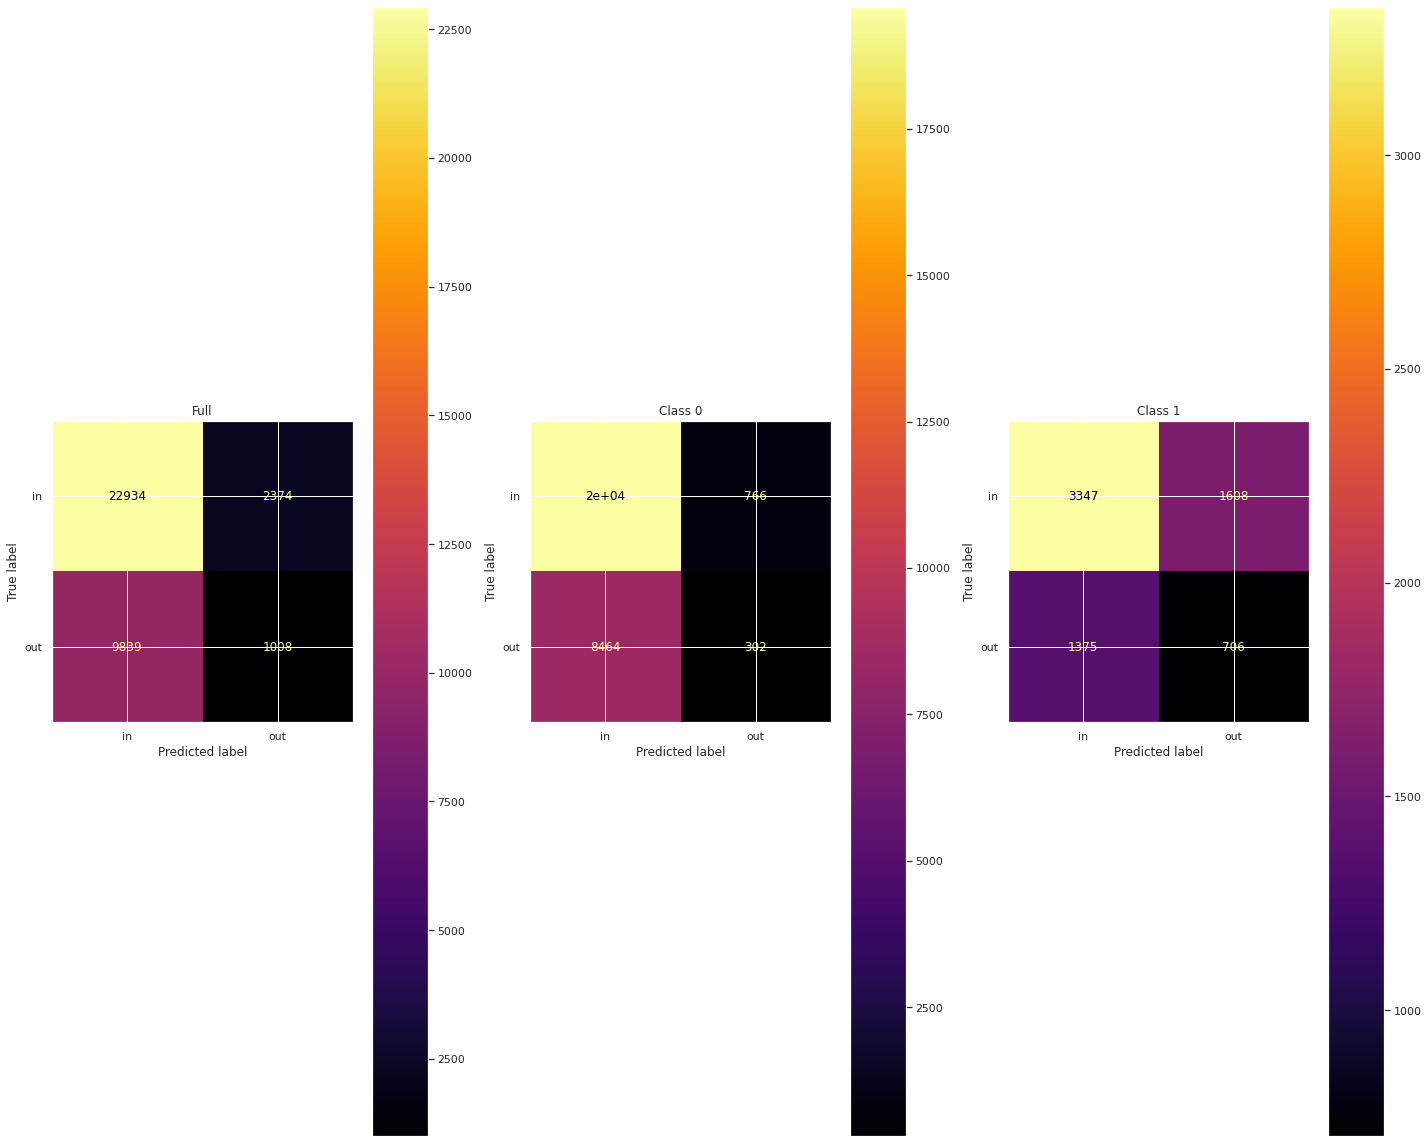

In [18]:
evaluate_attack(sv0, sv1, BB, BB_DATA)

Use the true label of the data instead of the one assigned by the black box in order to split the data before using the right ensemble

In [ ]:
evaluate_attack(sv0, sv1, BB, BB_DATA, split_true_label=True)

## 5 Most sure

In [19]:
ms5_0 = KMostSureVotingClassifier(classifiers=attack_models_0)
ms5_1 = KMostSureVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.92      0.80     25308
         out       0.29      0.08      0.12     10847

    accuracy                           0.67     36155
   macro avg       0.50      0.50      0.46     36155
weighted avg       0.58      0.67      0.59     36155


Class 0
              precision    recall  f1-score   support

          in       0.70      0.96      0.81     20353
         out       0.28      0.03      0.06      8766

    accuracy                           0.68     29119
   macro avg       0.49      0.50      0.43     29119
weighted avg       0.57      0.68      0.58     29119


Class 1
              precision    recall  f1-score   support

          in       0.71      0.75      0.73      4955
         out       0.30      0.25      0.27      2081

    accuracy                           0.61      7036
   macro avg       0.50      0.50      0.50      7036
weighted avg       0.59      0.61      0.60 

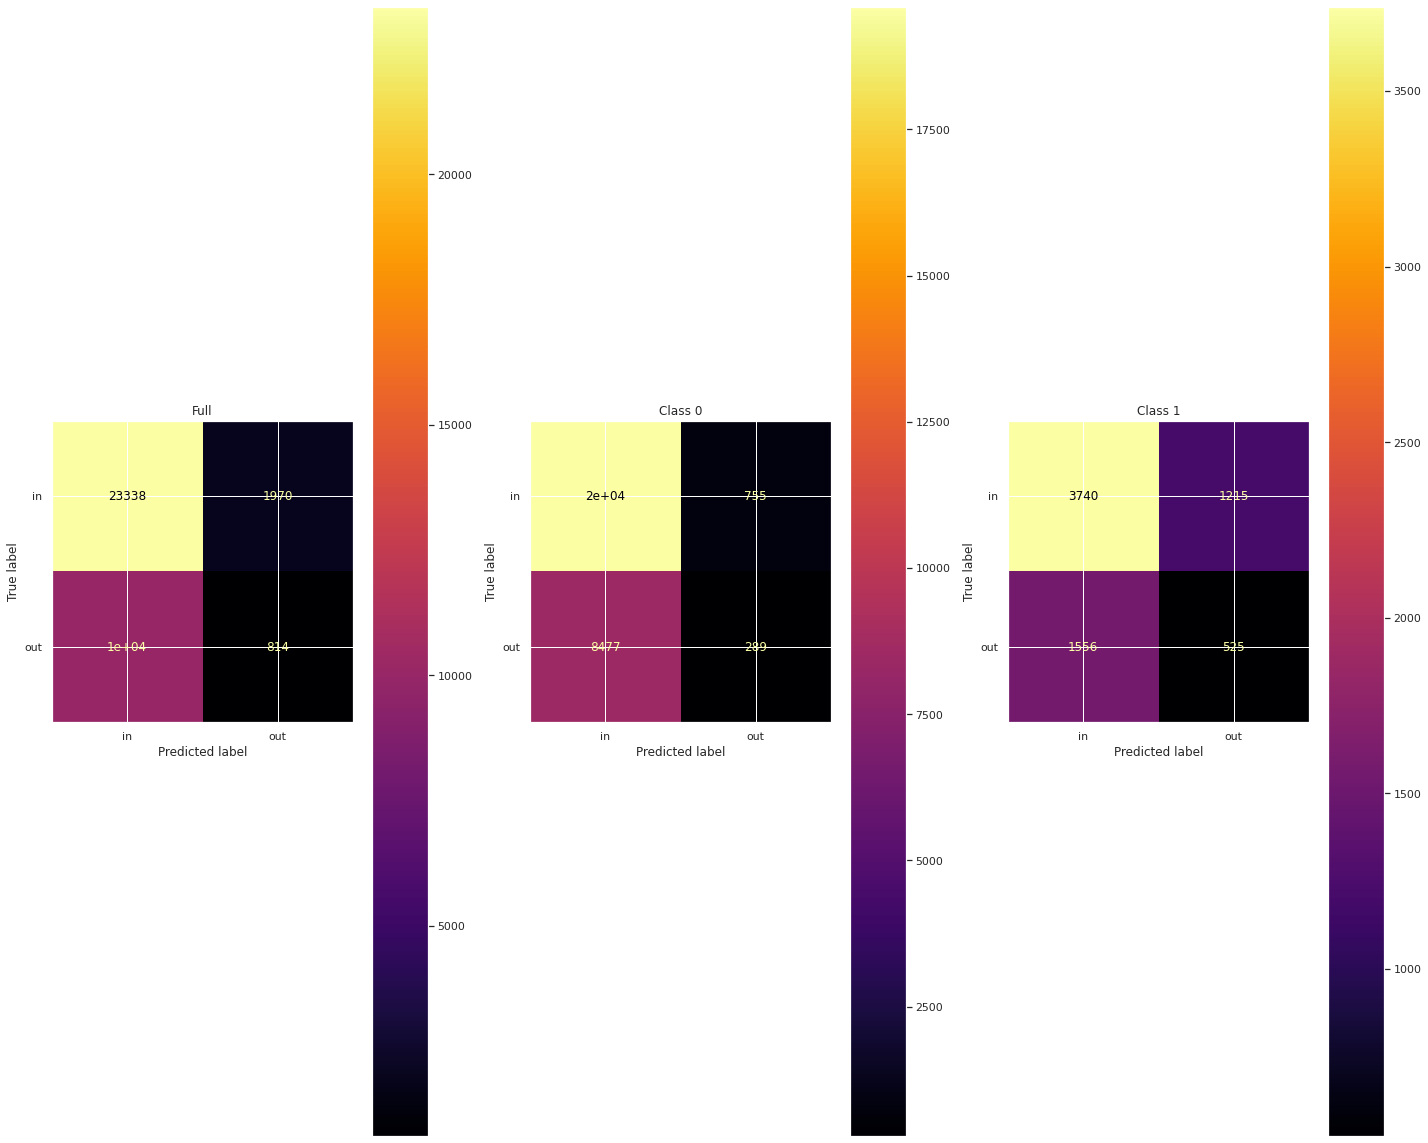

In [21]:
evaluate_attack(ms5_0, ms5_1, BB, BB_DATA)

Use the true label of the data instead of the one assigned by the black box in order to split the data before using the right ensemble

report full
              precision    recall  f1-score   support

          in       0.71      0.84      0.77     25308
         out       0.33      0.18      0.24     10847

    accuracy                           0.64     36155
   macro avg       0.52      0.51      0.50     36155
weighted avg       0.59      0.64      0.61     36155


Class 0
              precision    recall  f1-score   support

          in       0.70      0.88      0.78     20353
         out       0.33      0.14      0.20      8766

    accuracy                           0.66     29119
   macro avg       0.52      0.51      0.49     29119
weighted avg       0.59      0.66      0.61     29119


Class 1
              precision    recall  f1-score   support

          in       0.72      0.66      0.69      4955
         out       0.32      0.38      0.35      2081

    accuracy                           0.58      7036
   macro avg       0.52      0.52      0.52      7036
weighted avg       0.60      0.58      0.59 

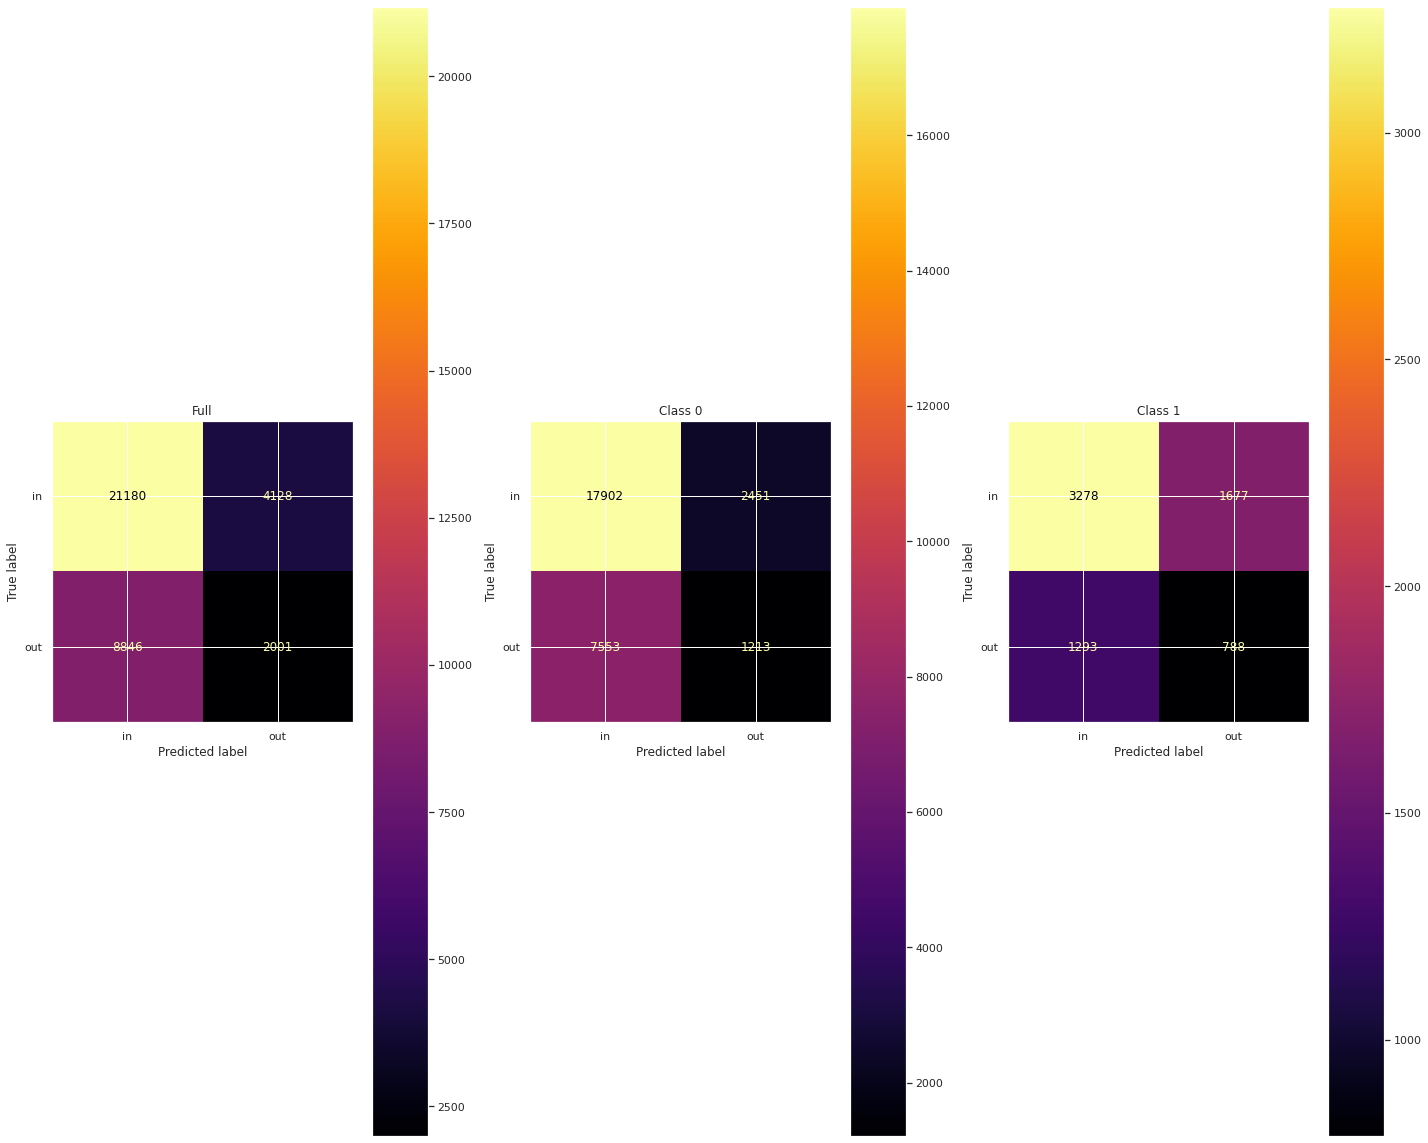

In [22]:
evaluate_attack(ms5_0, ms5_1, BB, BB_DATA, split_true_label=True)